In [104]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rickpy import get_sheet, ProgressBar
from olfactometer import odorants as o
sns.set(font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
o.get_compound_odor(7945, raw=True);

In [12]:
o.get_compound_odor(8093)

['FATTY, GREEN CHEESE AROMA',
 'FLORAL, BITTER, FRUITY (UNRIPE APPLE)',
 'Pleasant']

In [13]:
o.get_compound_odor(7945)

['ETHYL ISOVALERATE is a colorless oily liquid with a strong odor similar to apples. Less dense than water. Vapors heavier than air. May mildly irritate skin and eyes.']

In [14]:
# Two Google sheets of odor cabinet data
smith_cabinet = get_sheet('1PlU4zHyRXtcI7Y-O6xYtlIyKoKk8hX1I9zfx8KFELdc', 'smith-compounds').set_index('CID')
gerkin_cabinet = get_sheet('1PlU4zHyRXtcI7Y-O6xYtlIyKoKk8hX1I9zfx8KFELdc', 'gerkin-compounds').set_index('CID')

# Concatenate
x = pd.concat([gerkin_cabinet[['ChemicalName']], smith_cabinet[['ChemicalName']]])

# Drop duplicate CIDs
x = x.groupby(level=0).first()

x.head()

,ChemicalName
CID,
119,gamma-Aminobutyric acid
174,Poly(ethylene glycole)
176,"Acetic Acid, Glacial"
179,Acetoin
240,Benzaldeyhde


In [15]:
# Add odorant data from PubChem
p = ProgressBar(x.shape[0])
for i, CID in enumerate(x.index):
    p.animate(i)
    odor_info = o.get_compound_odor(CID)
    x.loc[CID, 'n_odor_mentions'] = int(len(odor_info))
    x.loc[CID, 'odor'] = ';'.join(odor_info)

[-----------------------99%----------------------] 264 out of 265 complete

In [32]:
kinds = {}

# Which CIDs contain no odor info
kinds['nothing'] = x[x['odor']==''].index

# Which CIDs are claimed to be odorless
kinds['odorless'] = x[x['odor'].str.lower().str.contains('odorless')].index

# Which CIDs have some other kind of odor information
kinds['odorous'] = x[~x.index.isin(nothing) & ~x.index.isin(odorless)].index

for kind in kinds:
    print("There are %d compounds in '%s'" % (len(kinds[kind]), kind))

There are 140 compounds in 'nothing'
There are 30 compounds in 'odorless'
There are 95 compounds in 'odorous'


In [18]:
# Get basic molecular properties (MW and octanol/water partition coefficient)
records = o.from_cids(x.index, property_list=['MolecularWeight', 'XlogP'])

Retrieving 0 through 99
Retrieving 100 through 199
Retrieving 200 through 264


In [19]:
# Add these records to the dataframe
# Skip XLogP when it isn't found
for record in records:
    x.loc[record['CID'], 'MW'] = record['MolecularWeight']
    try:
        x.loc[record['CID'], 'XLogP'] = record['XLogP']
    except KeyError:
        print(record['name'])

magnesium ion
potassium chloride
sodium chloride
histamine dihydrochloride
pilocarpine hydrochloride
tetraethylammonium chloride
acetylcholine chloride
yohimbine hydrochloride
choline chloride
boric acid
mecamylamine hydrochloride
potassium hydroxide
sodium hydroxide
selenocystine
7411-49-6
poloxamer 188
potassium alum
cadmium chloride
barium chloride
ammonium chloride
sodium selenate
potassium ferricyanide
butaclamol hydrochloride
brilliant blue r
ammonium persulfate
verapamil hydrochloride
delphinidin chloride
mianserin hydrochloride
trisodium citrate dihydrate
dimaprit dihydrochloride
1185-53-1
octopamine hydrochloride
methylene blue trihydrate
propidium iodide
28718-90-3
serotonin hydrochloride
titanium(iv) chloride
6138-23-4
cgp 54626 hydrochloride
lithium chloride
sodium bicarbonate
10049-21-5
potassium dihydrogen phosphate
potassium acetate
sodium acetate
ammonium acetate
sodium metabisulfite
sodium dimethylarsinate
75277-39-3
h-d-arg(no2)-ome hcl
sodium dodecyl sulfate
62625-28

(-10, 10)

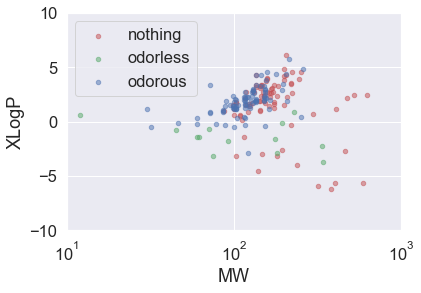

In [34]:
plt.figure()
ax = plt.gca()
for color, kind in {'r':'nothing', 'g':'odorless', 'b':'odorous'}.items():
    x.loc[kinds[kind]].plot.scatter(x='MW', y='XLogP', alpha=0.5, c=color, ax=ax, label=kind)
plt.xscale('log')
plt.xlim(10,1000)
plt.ylim(-10,10)

In [54]:
# Add odorant boiling point data from PubChem
p = ProgressBar(x.shape[0])
for i, cid in enumerate(x.index):
    p.animate(i)
    z = o.get_compound_summary(cid, 'Boiling Point')
    if z and len(z):
        x.loc[cid, 'BP'] = str(o._parse_other_info(z)[0])

[-----------------------99%----------------------] 264 out of 265 complete

In [105]:
# Parse this into boiling points in Celsius
for cid, bp_raw in x['BP'].iteritems():
    if isinstance(bp_raw,str):#math.isnan(bp_raw):
        num = re.findall("[-+]?[0-9]*\.?[0-9]+", bp_raw)[0]
        units = None
        if any([s in bp_raw for s in ['° F','°F','deg F','DEG F']]):
            units = 'F' 
        if any([s in bp_raw for s in ['° C','°C','deg C','DEG C']]):
            units = 'C'
        #print(cid, num, units)
        if units == 'C':
            bp_C = float(num)
        elif units == 'F':
            bp_C = (5.0/9) * (float(num) - 40)
        if units:
            x.loc[cid, 'BP_C'] = bp_C

(-10, 10)

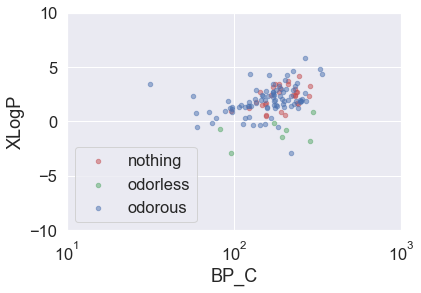

In [106]:
plt.figure()
ax = plt.gca()
for color, kind in {'r':'nothing', 'g':'odorless', 'b':'odorous'}.items():
    x.loc[kinds[kind]].plot.scatter(x='BP_C', y='XLogP', alpha=0.5, c=color, ax=ax, label=kind)
plt.xscale('log')
plt.xlim(10,1000)
plt.ylim(-10,10)